# Building a Spam Filter with Naive Bayes
### Introduction

In this project, we used the Naive Bayes technique to build a spam classifier for SMS messages. To train the classifier to distinguish between spam and non-spam messages, we used the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that were manually classified by humans.

### Data

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from <a href='https://archive.ics.uci.edu/ml/datasets/sms+spam+collection'>The UCI Machine Learning Repository</a>. The data collection process along is described in more details <a href='http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition'>on this page</a>. The authors' papers related to the above-mentioned dataset can be found also by following <a href='http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition'>this link</a>.

### Outcome

In this project, we managed to build a spam classifier for SMS messages using the multinomial Naive Bayes algorithm. Due to effective text preprocessig techniques and feature engineering, we achieved accuracy of 98.56% on the test set.

## Data Exploration
### Read in the data

In [1]:
import pandas as pd
import numpy
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from IPython.display import Image, display
import re

nltk.download('stopwords')
nltk.download('wordnet')

# enable visualizations
import matplotlib.pyplot as plt
%matplotlib inline

# apply ggplot style to matplotlib graphs
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruslankononov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ruslankononov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('SMSSpamCollection',sep='\t',header=None,names=['class_name','sms_text'])

In [3]:
data.head(10)

,class_name,sms_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  5572 non-null   object
 1   sms_text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


As we see, the dataset has 5572 rows and two columns. Luckily, there are no missing / NaN values. Let's now check distribution of messages in our dataset by their class name. We know that our messages can be either ham or spam.

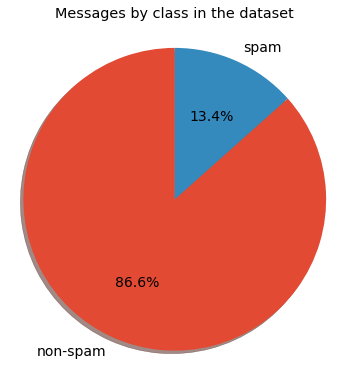

In [5]:
value_dist = data.class_name.value_counts(normalize=True)*100

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(value_dist, labels=['non-spam','spam'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
ax1.axis('equal') 
ax1.title.set_fontsize(16)
plt.title("Messages by class in the dataset", y = 1.04)
plt.ylabel("")

plt.show()

The graph above displays that almost __87% of the messages__ in the dataset __are ham (non-spam)__, and the remaining __13% are spam__.

## Splitting Dataset Into a Training and a Test Set

Before training our classifiers, we are first going to __split our dataset into two parts__:

- A __training set__, which we will use to "train" our classifiers.
- A __test set__, which we will use to test performance of our classifiers.

We are going to keep __80% of our dataset for training__, and __20% for testing__. As our dataset has 5,572 messages:

- The training set will have 4,458 messages (about 80% of the dataset).
- The test set will have 1,114 messages (about 20% of the dataset).

__Let's start by randomizing the entire dataset__ to ensure that spam and ham messages are distributed randomly throughout the dataset.
### Randomizing the dataset

In [6]:
# randomize the dataset
data_randomized = data.sample(frac=1,random_state=1)

# calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

# create a training and a test set
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [7]:
# compare distribution of values in training and test sets
value_dist_training = training_set.class_name.value_counts(normalize=True)*100
value_dist_test = test_set.class_name.value_counts(normalize=True)*100

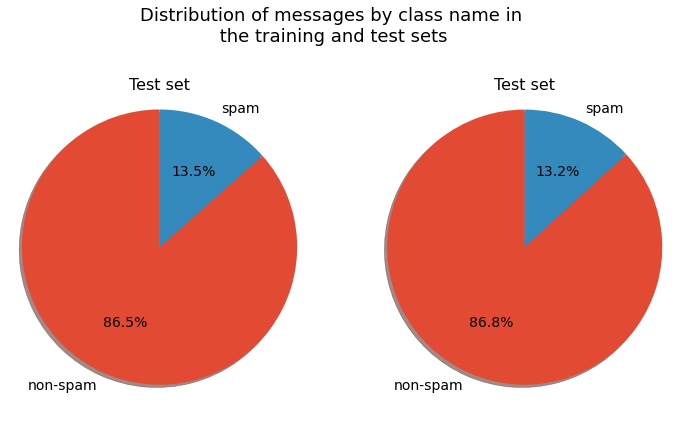

In [8]:
# display distribution of values in training and test sets
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(1,2,1)
ax1.pie(value_dist_training, labels=['non-spam','spam'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
ax1.axis('equal')  
ax1.set_title('Test set', y=0.9, size=16)

ax2 = fig.add_subplot(1,2,2)
ax2.pie(value_dist_test, labels=['non-spam','spam'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
ax2.axis('equal')
ax2.set_title('Test set', y=0.9, size=16)
fig.suptitle('Distribution of messages by class name in\n the training and test sets', fontsize=18)
plt.show()

The graph above demonstrates that the test set and the training set have similar distribution of target classes. Thus, __all the assumptions that we will infer from data in the training set must be valid for data in the test set too.__
## Data Cleaning
The next big step is to use our training data to train the algorithm to classify messages. __To start calculating parameters for a Naive Bayes classifier, we will__ first need to perform a bit of data cleaning to __bring the data in a format that will allow us to extract easily all the information we need__.

In particular, we would like to bring the data to the following format:

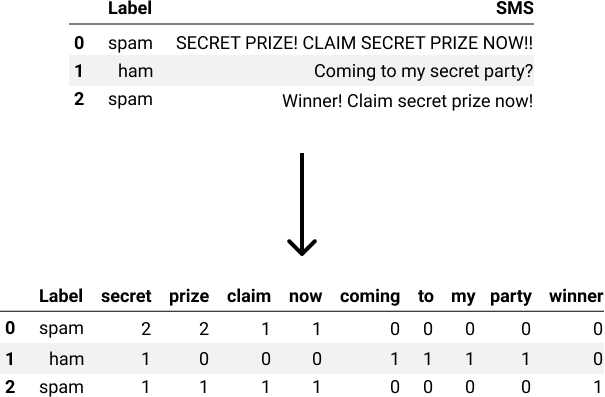

In [9]:
display(Image('pic1.png'))

### Letter case and punctuation
We will begin the data cleaning process by removing the punctuation and bringing all the words to lower case.

In [10]:
# data before cleaning
training_set.head(7)

,class_name,sms_text
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...
5,ham,Ok i thk i got it. Then u wan me 2 come now or...
6,ham,I want kfc its Tuesday. Only buy 2 meals ONLY ...


In [11]:
# remove remove all the punctuation, leading and trailing spaces and convert string to lowercase
training_set['sms_clean'] = training_set['sms_text'].str.replace('\W',' ').str.lower()
training_set['sms_clean'] = training_set['sms_clean'].str.replace('\s+',' ').str.strip()

# data after cleaning
training_set.head(7)

<ipython-input-11-ccb9de98215f>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  training_set['sms_clean'] = training_set['sms_text'].str.replace('\W',' ').str.lower()
<ipython-input-11-ccb9de98215f>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  training_set['sms_clean'] = training_set['sms_clean'].str.replace('\s+',' ').str.strip()


,class_name,sms_text,sms_clean
0,ham,"Yep, by the pretty sculpture",yep by the pretty sculpture
1,ham,"Yes, princess. Are you going to make me moan?",yes princess are you going to make me moan
2,ham,Welp apparently he retired,welp apparently he retired
3,ham,Havent.,havent
4,ham,I forgot 2 ask ü all smth.. There's a card on ...,i forgot 2 ask ü all smth there s a card on da...
5,ham,Ok i thk i got it. Then u wan me 2 come now or...,ok i thk i got it then u wan me 2 come now or wat
6,ham,I want kfc its Tuesday. Only buy 2 meals ONLY ...,i want kfc its tuesday only buy 2 meals only 2...


### Removing stop words and lemmatisation
Now we will create a vocabulary for the messages in the training set. The vocabulary will be a list containing all the unique words across all messages, where each word is represented as a string.

In [12]:
# transform each message from the SMS column into a list of words
training_set['sms_clean'] = training_set['sms_clean'].str.split(" ")

However, not all the words should end up in our vocabulary. It can be the case that some of the words may not provide any useful information or context to classify a message. For instance, prepositions like *`in`* and *`at`*, or conjunctions such as *`just`* and *`for`* are quite frequent but do not add much meaning to a sentence. Therefore, we can safely exclude them from the scope without sacrificing the meaning of the text. Additionally, we will remove all the numbers from our text messages.

In [13]:
# create a set of the stopwords 
stop_words = stopwords.words("english")

In [14]:
def remove_stepwords(text):
    new_text = list()
    for word in text:
        if word not in stop_words and not word.isdigit():
            new_text.append(word)
    return new_text

# remove the stopwords and numbers from the text
training_set['sms_clean'] = training_set['sms_clean'].apply(remove_stepwords)

In [15]:
training_set['sms_clean'].head()

0                             [yep, pretty, sculpture]
1                   [yes, princess, going, make, moan]
2                          [welp, apparently, retired]
3                                             [havent]
4    [forgot, ask, ü, smth, card, da, present, lei,...
Name: sms_clean, dtype: object

Appart from functional words, our vocabulary can contain various versions of a single word. For instance, for grammatical reasons, the word *`organise`* can have multiple forms, such as *`organises`*, *`organising`*, *`organised`*. Moreover, there can be families of related words with similar meanings. For example, words such as *`democratic`* and *`democratisation`* all stem from the word *`democracy`*. We can assume that, in most cases, having only a base form of a word is more than enough to determine a class of a message. The process of reducing various related forms of a word to its common base form is called lemmatization. 

Thus, let's lemmatise the words in our dataset.

In [16]:
lemmatizer = WordNetLemmatizer()

# lemmatise text
def lemmatize_word(text):
    new_text = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return new_text

In [17]:
training_set['sms_clean'] = training_set['sms_clean'].apply(lemmatize_word)

## Creating Vocabulary

In [18]:
vocabulary = []

for row in training_set['sms_clean']:
    for word in row:
        vocabulary.append(word)

# remove duplicates from the vocabulary
vocabulary = list(set(vocabulary))

In [19]:
word_counts_per_sms = {unique_word: [0] * len(training_set['sms_clean']) for unique_word in vocabulary}
                             
for index, sms in enumerate(training_set['sms_clean']):
    for word in sms:
        if not word.isdigit():
            word_counts_per_sms[word][index] += 1                          

In [20]:
word_counts = pd.DataFrame(data=word_counts_per_sms) 
word_counts = word_counts.drop("",axis=1)
word_counts.head()

,rp176781,vibrant,lambda,lionp,okmail,fran,merry,gas,wear,wicket,...,officially,cake,urination,stressfull,light,fgkslpo,dice,2watershd,cab,recognise
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
training_data_clean = pd.concat([training_set, word_counts], axis=1)
training_data_clean.head()

,class_name,sms_text,sms_clean,rp176781,vibrant,lambda,lionp,okmail,fran,merry,...,officially,cake,urination,stressfull,light,fgkslpo,dice,2watershd,cab,recognise
0,ham,"Yep, by the pretty sculpture","[yep, pretty, sculpture]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"Yes, princess. Are you going to make me moan?","[yes, princess, go, make, moan]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,Welp apparently he retired,"[welp, apparently, retire]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,Havent.,[havent],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,I forgot 2 ask ü all smth.. There's a card on ...,"[forget, ask, ü, smth, card, da, present, lei,...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculating Constants
Now that we are done with data cleaning and have a training set to work with, we can begin creating the spam filter. 
As we know, the Naive Bayes algorithm will need to know the probability values of the two equations below to be able to classify new messages:

![](pic2.png)
Also, to calculate $\ P(w_i|Spam)$ and $\ P(w_i|Ham)$ inside the formulas above, we need to use these equations:
![](pic3.png)
- $\ N_{Spam}$ is equal to the number of words in all the spam messages — it's not equal to the number of spam messages, and it's not equal to the total number of unique words in spam messages.
- $\ N_{Ham}$ is equal to the number of words in all the non-spam messages — it's not equal to the number of non-spam messages, and it's not equal to the total number of unique words in non-spam messages.
- $\ N_{Vocabulary}$ is equal to the number of unique words.

We will also use Laplace smoothing and set $\ α=1$. 



In [22]:
# isolate spam and ham messages 
spam_messages = training_data_clean[training_data_clean['class_name'] == 'spam']
ham_messages = training_data_clean[training_data_clean['class_name'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_data_clean)
p_ham = len(ham_messages) / len(training_data_clean)

# N_Spam
n_words_per_spam_message = spam_messages['sms_clean'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['sms_clean'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

## Calculating Parameters
Now that we have the constant terms calculated above, we can move on with calculating the parameters $P(w_i|Spam)$ and $P(w_i|Ham)$. Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

The parameters are calculated using the formulas:
$$
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
$$$$
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
$$

In [23]:
vocabulary.remove('')

denom_spam = n_spam + n_vocabulary
denom_ham = n_ham + n_vocabulary

# calculate parameters
parameters_spam = {word: ((spam_messages[word].sum()+1)/denom_spam) for word in vocabulary}
parameters_ham = {word: ((ham_messages[word].sum()+1)/denom_ham) for word in vocabulary}

## First Round of Testing


Now that we have all our parameters calculated, we can start creating the spam filter. The spam filter can be understood as a function that:
- Takes in as input a new message (w$_1$, w$_2$, ..., w$_n$) 
- Calculates P(Spam|w$_1$, w$_2$, ..., w$_n$) and P(Ham|w$_1$, w$_2$, ..., w$_n$).
- Compares the values of P(Spam|w$_1$, w$_2$, ..., w$_n$) and P(Ham|w$_1$, w$_2$, ..., w$_n$), and:
    - If P(Ham|w$_1$, w$_2$, ..., w$_n$) > P(Spam|w$_1$, w$_2$, ..., w$_n$), then the message is classified as ham.
    - If P(Ham|w$_1$, w$_2$, ..., w$_n$) < P(Spam|w$_1$, w$_2$, ..., w$_n$), then the message is classified as spam.
    - If P(Ham|w$_1$, w$_2$, ..., w$_n$) = P(Spam|w$_1$, w$_2$, ..., w$_n$), then the algorithm may request human help.

In [24]:
import re 

def classify(message):

    message = re.sub('\W', ' ', message)
    message = re.sub('\s+', ' ', message)
    message = re.sub('\d+', ' ', message)
    message = message.lower()
    message = message.split()
    message = lemmatize_word(message)
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham 
    
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]    

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'requires human classification'

Now we can test our function _classify( )_ with one spam and one non-spam message.

In [25]:
# test function with a spam message
message_spam = "WINNER!! This is the secret code to unlock the money: C3421."
print(classify(message_spam))

spam


In [26]:
# test function with a ham message
message_ham = "Sounds good, Tom, then see u there"
print(classify(message_ham))

ham


As we can see, the function works correctly. Now __let's test our classifier on the test set__. To evaluate performance of the classifier, we will use __accuracy__ as a metric:

In [27]:
# apply function to the test set
test_set['predicted'] = test_set['sms_text'].apply(classify)
test_set.head()

,class_name,sms_text,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [28]:
correct = test_set.class_name == test_set.predicted
print("Correct: {}".format(correct.sum()))
print("Incorrect {}".format(len(test_set)-correct.sum()))
print("Accuracy: {}".format(correct.sum()/len(test_set)*100))

Correct: 1094
Incorrect 20
Accuracy: 98.20466786355476


So for, we have managed to build a spam classifier based on the multinomial Naive Bayes algorithm that achieves __accuracy of 98.20% on the test set__. This is undoubtedly an excellent result. Nevertheless, we can see that 20 messages have been classified incorrectly. Let's have a look at them to see if we can somehow improve our algorithm. 

## Additional Tuning and Feature Engineering

In [29]:
# show entire text in a column
pd.set_option('display.max_colwidth', None)
# display misclassified messages
test_set[test_set['predicted']!=test_set['class_name']][['class_name','sms_text']]

,class_name,sms_text
114,spam,Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net
135,spam,More people are dogging in your area now. Call 09090204448 and join like minded guys. Why not arrange 1 yourself. There's 1 this evening. A£1.50 minAPN LS278BB
152,ham,Unlimited texts. Limited minutes.
182,ham,Surely result will offer:)
195,ham,Hi.:)technical support.providing assistance to us customer through call and email:)
263,spam,TheMob>Yo yo yo-Here comes a new selection of hot downloads for our members to get for FREE! Just click & open the next link sent to ur fone...
284,ham,Nokia phone is lovly..
319,ham,"We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us"
363,spam,Email AlertFrom: Jeri StewartSize: 2KBSubject: Low-cost prescripiton drvgsTo listen to email call 123
500,spam,"Ur balance is now £600. Next question: Complete the landmark, Big, A. Bob, B. Barry or C. Ben ?. Text A, B or C to 83738. Good luck!"


As we can see above, __there are two distinctive features of spam messages that we tend to discard during the pre-processing phase__. Firstly, 4 __spam messages__ out of 12 messages __have a currency sign__ - `£`. Secondly, __spam messages tend to have words in capital letters__. The latter may help scammers / spammers attract receivers' attention and urge them to act without giving it a second thought. __Let's check if both our assumptions are valid__. 

In [30]:
# if there is a currency sign in a message, 'money_sign' feature equals 1, otherwise 0
training_set['money_sign'] = training_set.apply(lambda x:1 if '£' in x['sms_text'] else 0, axis=1)

# calculate total number of messages containing currency sign by target class name in the training set  
group1 = training_set[['money_sign','class_name']].groupby(by='class_name').sum().reset_index()

# calculate total number of ham messages in the training set  
n_ham_messages = (training_set['class_name']=='ham').sum()

# calculate total number of spam messages in the training set  
n_spam_messages = (training_set['class_name']=='spam').sum()

# calculate fractions
group1['fraction'] = group1.apply(lambda x:(x.money_sign/n_ham_messages) if x.class_name=='ham' else (x.money_sign/n_spam_messages),axis=1)
group1['fraction'] = round(group1['fraction'] * 100,2)
group1

,class_name,money_sign,fraction
0,ham,5,0.13
1,spam,204,34.00


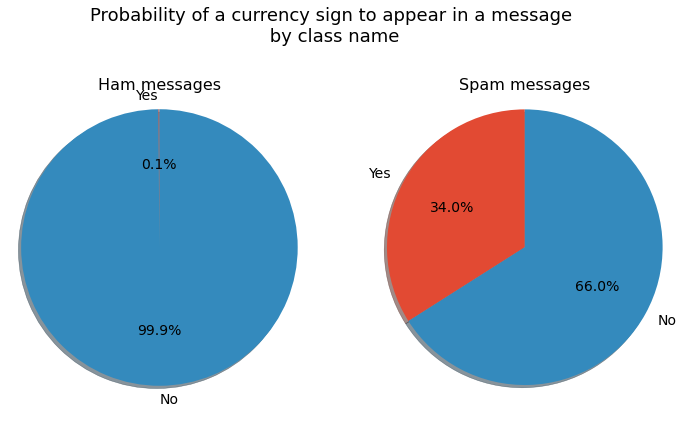

In [31]:
# display distribution of currency sign in the training sets by target class
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(1,2,1)
ax1.pie([group1['fraction'].iloc[0], 100-group1['fraction'].iloc[0]], labels=['Yes','No'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
ax1.axis('equal')  
ax1.set_title('Ham messages', y=0.9, size=16)

ax2 = fig.add_subplot(1,2,2)
ax2.pie([group1['fraction'].iloc[1], 100-group1['fraction'].iloc[1]], labels=['Yes','No'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
ax2.axis('equal')
ax2.set_title('Spam messages', y=0.9, size=16)
fig.suptitle('Probability of a currency sign to appear in a message\n by class name', fontsize=18)
plt.show()

__The graph above vividly shows that spam messages are more likely to contain currency signs__. Therefore, our initial assumption has been valid. __We can add__ `money_sign` __to our corpus of parameters__. Let's check if our assumption holds true regarding words in capital letters.

In [32]:
import re

def calc_uppercase_words(text):
    return len(re.findall(r"\b[A-Z]{2,}\b", text))

training_set['has_caps'] = training_set['sms_text'].apply(calc_uppercase_words) 

# calculate total number of messages containing currency sign by target class name in the training set  
group2 = training_set[['has_caps','class_name']].groupby(by='class_name').sum().reset_index()

# calculate fractions
group2['fraction'] = group2.apply(lambda x:(x.has_caps/n_ham) if x.class_name=='ham' else (x.has_caps/n_spam),axis=1)
group2['fraction'] = round(group2['fraction'] * 100,2)
group2

,class_name,has_caps,fraction
0,ham,1588,5.11
1,spam,1279,13.95


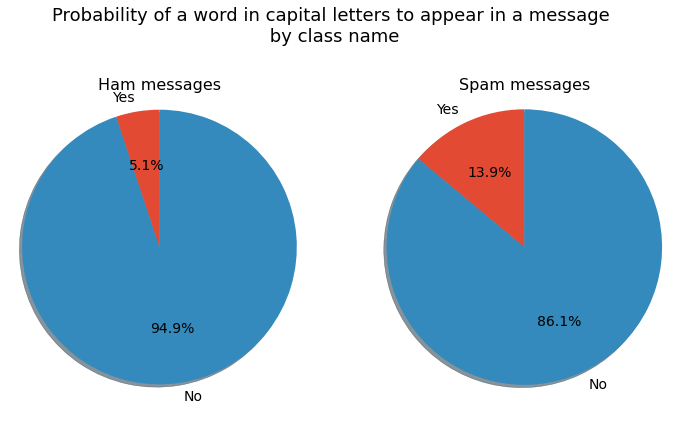

In [33]:
# display probability of words in capital letters in the training sets by target class
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(1,2,1)
ax1.pie([group2['fraction'].iloc[0], 100-group2['fraction'].iloc[0]], labels=['Yes','No'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
ax1.axis('equal')  
ax1.set_title('Ham messages', y=0.9, size=16)

ax2 = fig.add_subplot(1,2,2)
ax2.pie([group2['fraction'].iloc[1], 100-group2['fraction'].iloc[1]], labels=['Yes','No'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
ax2.axis('equal')
ax2.set_title('Spam messages', y=0.9, size=16)
fig.suptitle('Probability of a word in capital letters to appear in a message\n by class name', fontsize=18)
plt.show()

__The numbers on the graph above suggest that words in capital letters are also more likely to appear in spam messages__. Therefore, both our assumption are valid. We will add `has_caps` and `money_sign` to the corpus of parameters and then check the performance of our classifier. However, before we start recalculating our parameters, let's also check top 20 words with the highest probability of occuring in spam and ham messages.

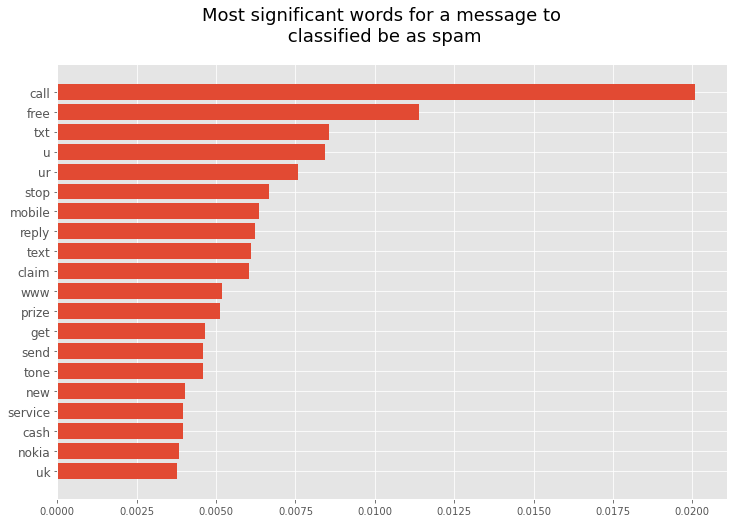

In [34]:
series_spam = pd.Series(parameters_spam)
series_spam = series_spam.sort_values(ascending=False)[:20]

fig, ax = plt.subplots(figsize=(12,8))
ax.barh(series_spam.index,series_spam)
plt.setp(ax.get_yticklabels(),size=12)
ax.invert_yaxis()
fig.suptitle('Most significant words for a message to\n classified be as spam', fontsize=18)
plt.show()

As we can see, __some of the words such as__ `free`, `prize`, `www`, `claim`, __or__ `cash` __we naturally expect to enconter in spam messages__. However, __words like__ `u` __or__ `ur` __seem to be common in any context__. Therefore, __we will exclude those two words from our vocabulary__.

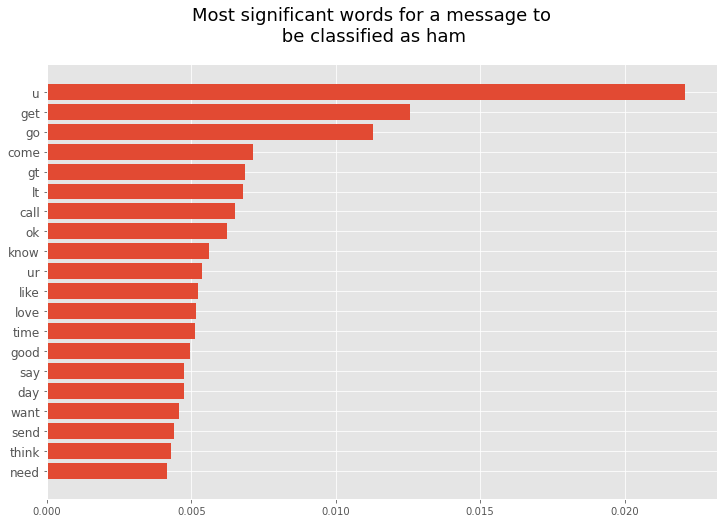

In [35]:
series_ham = pd.Series(parameters_ham)
series_ham = series_ham.sort_values(ascending=False)[:20]

# display distribution of values in training and test sets
fig, ax = plt.subplots(figsize=(12,8))
ax.barh(series_ham.index,series_ham)
plt.setp(ax.get_yticklabels(),size=12)
ax.invert_yaxis()
fig.suptitle('Most significant words for a message to\n be classified as ham', fontsize=18)
plt.show()

Based on the graph above, __we can conclude that most of the presented words seem to suit the context of ham messages quite well. However, as in the previous graph, the words__ `u` __and__ `ur` __should not be in our vocabulary__. 

In [36]:
# remove words from the vocabularly
vocabulary.remove('u') 
vocabulary.remove('ur') 

## Re-calculating Parameters
Since we have now finised our investigation, let's calculate parameters for two more features - `money_sign` and `has_caps`. We assume that adding those two features may help improve accuracy of our classifier.

In [37]:
# add features to the vocabulary
vocabulary.append('money_sign') 
vocabulary.append('has_caps') 

In [38]:
# add frequencies of the features to the training data set
training_data_clean['has_caps'] = training_set['has_caps']
training_data_clean['money_sign'] = training_set['money_sign']

spam_messages = training_data_clean[training_data_clean['class_name'] == 'spam']
ham_messages = training_data_clean[training_data_clean['class_name'] == 'ham']

In [39]:
# recalculate parameters
parameters_spam = {word: ((spam_messages[word].sum()+1)/denom_spam) for word in vocabulary}
parameters_ham = {word: ((ham_messages[word].sum()+1)/denom_ham) for word in vocabulary}

In [40]:
# update the function 
def classify(message):
    
    money_sign = False
    
    # check if there is any money sign in the input message
    if '£' in message:
        money_sign = True
        
    # calculate number of words in capital in the input message
    n_capitals = calc_uppercase_words(message)
    
    # preprocess input message
    message = re.sub('\W', ' ', message)
    message = re.sub('\s+', ' ', message)
    message = re.sub('\d+', ' ', message)
    message = message.lower()
    message = message.split()
    message = lemmatize_word(message)

    if money_sign:
        message.append('money_sign')
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham 
    
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
            
    if n_capitals > 0:
        p_spam_given_message *= parameters_spam['has_caps']
        p_ham_given_message *= parameters_ham['has_caps']

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'requires human classification'

In [41]:
# apply function to the test set
test_set['predicted'] = test_set['sms_text'].apply(classify)
test_set.head()

,class_name,sms_text,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Orange camera/video phones for FREE. Save £s with Free texts/weekend calls. Text YES for a callback orno to opt out,spam
3,ham,All sounds good. Fingers . Makes it difficult to type,ham
4,ham,"All done, all handed in. Don't know if mega shop in asda counts as celebration but thats what i'm doing!",ham


In [42]:
correct = test_set.class_name == test_set.predicted
print("Correct: {}".format(correct.sum()))
print("Incorrect {}".format(len(test_set)-correct.sum()))
print("Accuracy: {}".format(correct.sum()/len(test_set)*100))

Correct: 1098
Incorrect 16
Accuracy: 98.56373429084381


Now, __due to feature engineering and more closer look into the data, we have achieved a superior performance of the classifier__. So let's now make our conclusions.

## Conclusions

In this project, we have learnt than:

- assigning probabilities to events based on conditional probability rules and using Bayes' theorem is still a valid approach that yields good results.
- create a spam classifier for SMS messages using the multinomial Naive Bayes algorithm can help build a fairly simple and fully interpretable classifier.
- digging into training data may help find inconsistencies, engineer new features or make interesing observations that improve performance and robustness of the classifier. 